# Importación de las librerías a utilizar

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

# Corpus de documentos que se van a analizar

In [2]:
corpus = ['El cielo es azul y luminoso.',
          '¡Me encanta este cielo azul y luminoso!',
          'El zorro marrón es rápido y salta sobre el perro que es dormilón.',
          'Un desayuno real tiene salchichas, jamón, bacon, huevos, tostadas y queso',
          '¡Me encanta el jamón, los huevos, las salchichas y el bacon!',
          '¡El zorro marrón es rápido, y el perro azul es un dormilón!',
          'El cielo es azul intenso y hoy está muy luminoso',
          '¡El perro es un dormilón, pero el zorro es mu rápido!'
]
labels = ['tiempo', 'tiempo', 'animales', 'alimentos', 'alimentos', 'animales', 'tiempo', 'animales']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,El cielo es azul y luminoso.,tiempo
1,¡Me encanta este cielo azul y luminoso!,tiempo
2,El zorro marrón es rápido y salta sobre el perro que es dormilón.,animales
3,"Un desayuno real tiene salchichas, jamón, bacon, huevos, tostadas y queso",alimentos
4,"¡Me encanta el jamón, los huevos, las salchichas y el bacon!",alimentos
5,"¡El zorro marrón es rápido, y el perro azul es un dormilón!",animales
6,El cielo es azul intenso y hoy está muy luminoso,tiempo
7,"¡El perro es un dormilón, pero el zorro es mu rápido!",animales


# Preprocesamiento

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('spanish')

def normalize_document(doc):
    # se pasa a minúsculas, se eliminan caracteres especiales y espacios
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenizado
    tokens = wpt.tokenize(doc)
    # filtro de stopwords: sólo se añaden los tokens que no figuran en la lista de stop-words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Y se vuelve a crear el documento doc antes de devolverlo
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['cielo azul luminoso', 'encanta cielo azul luminoso',
       'zorro marrn rpido salta perro dormiln',
       'desayuno real salchichas jamn bacon huevos tostadas queso',
       'encanta jamn huevos salchichas bacon',
       'zorro marrn rpido perro azul dormiln',
       'cielo azul intenso hoy est luminoso',
       'perro dormiln zorro mu rpido'], dtype='<U57')

# Word Embeddings

## Vamos a utilizar el modelo word2vec sobre nuestro ejemplo

Es un corpus pequeño, pero no vamos a utilizar un modelo pre-entrenado, sino que vamos a entrenar los embeddings sobre nuestro propio corpus

In [5]:
from gensim.models import word2vec

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Ajustamos los valores de los parámetros del entrenamiento

feature_size = 10       # Dimensión de los vectores que constituyen los embeddings  
window_context = 10     # Tamaño de la "Ventana de Contexto", número de palabras "vecinas" que analizamos                                                                       
min_word_count = 1      # Si una palabra aparece menos veces en el corpus, no se utiliza para los embeddings                        
sample = 1e-3           # Las palabras con una frecuencia superior se disminuyen en la muestra

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

## Visualización de los embeddings

Los embeddings son vectores de n dimensiones, en nuestro caso 10. Queremos visualizarlos en un el plano en dos dimensiones, en un diagrama XY, así que utilizaremos TSNE, que es un visualizador de sklearn

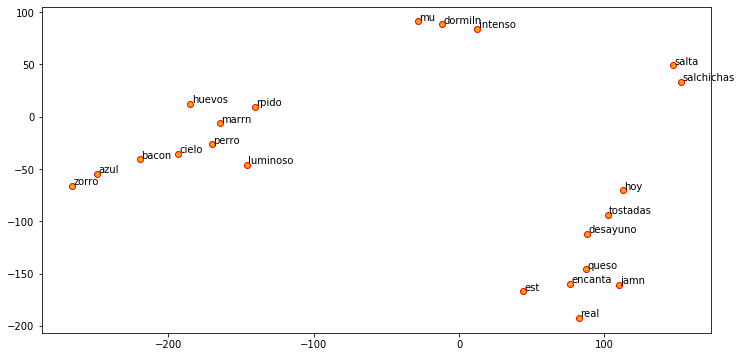

In [6]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Embedding de un término

In [7]:
w2v_model.wv['perro']

array([-0.00370714, -0.02361061,  0.00631267,  0.04281464, -0.04004161,
       -0.03179809, -0.03355134, -0.00736617, -0.01540621, -0.04960135],
      dtype=float32)

## Build framework for getting document level embeddings

In [8]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [9]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

/Users/francisco/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9
0,0.029742,-0.016293,0.014218,0.020311,-0.015504,-0.006757,-0.033506,0.000835,-0.000127,-0.009841
1,0.014729,-0.020805,0.020777,0.017686,-0.016781,-0.010418,-0.016585,0.000085,-0.001157,-0.001761
2,0.015559,0.002130,0.006996,0.009721,-0.017225,-0.015671,-0.002135,-0.009240,0.011026,-0.036327
3,-0.003321,-0.018404,-0.009007,0.006258,-0.004588,-0.017175,0.010354,-0.010729,-0.003359,0.024509
4,0.003828,-0.018030,0.003645,-0.004920,-0.011131,-0.031044,0.003618,-0.001826,-0.005052,0.021406
5,0.017146,-0.009619,0.018807,0.006814,-0.024165,-0.008187,-0.013674,-0.012150,0.010947,-0.028498
6,0.007726,0.003905,0.011628,0.011089,-0.002504,-0.005764,-0.024858,0.015804,0.006315,0.007090
7,0.017575,-0.001601,0.022747,0.013833,-0.021658,-0.005994,-0.006047,-0.003662,0.010574,-0.043146


## Clustering with word embeddings

In [10]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,El cielo es azul y luminoso.,tiempo,0
1,¡Me encanta este cielo azul y luminoso!,tiempo,0
2,El zorro marrón es rápido y salta sobre el perro que es dormilón.,animales,2
3,"Un desayuno real tiene salchichas, jamón, bacon, huevos, tostadas y queso",alimentos,1
4,"¡Me encanta el jamón, los huevos, las salchichas y el bacon!",alimentos,1
5,"¡El zorro marrón es rápido, y el perro azul es un dormilón!",animales,2
6,El cielo es azul intenso y hoy está muy luminoso,tiempo,0
7,"¡El perro es un dormilón, pero el zorro es mu rápido!",animales,2


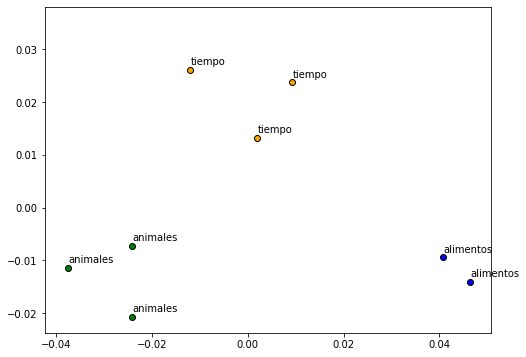

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

# Comentarios

Se puede observar la distribució  de los 8 documentos, con las etiquetas que se habían asignado inicialmente para identificarlos. Se observa que los 3 documentos que hablan de animales están muy cercanos, y es fácil interpretar que el algoritmo los coloque en un mismo cluster. Esto no ocurre con uno de los documentos relacionados con el tiempo, que se encuentra más cerca de los etiquetados como de animales. De ahí que en la distribución de cluster que hemos visto anteriormente, uno de ellos estuviera mal clasificado.

En un corpus tan breve no aporta ventajas claras utilizar embeddings frente a la alternativa de obtener una matriz Tf-Idf y luego una matriz de similitud.

Como se ha utilizado un modelo sin entrenar y el entrenamiento se ha realizado sobre nuestro corpus, hemos podido utilizar Word2Vec en español sin problemas. Existe la opción de cargar un modelo ya entrenado, y en ese caso sí que tendríamos que tener en cuenta el idioma, y descargar el modelo adecuado.

Dos buenos tutoriales sobre la utilización de Word2Vec son los siguientes:

https://unipython.com/curso-de-procesamiento-de-textos-gensim/

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html



## Utilización de GloVe Embeddings desde spaCy

En esta ocasión vamos a utilizar GloVe embeddings a nivel de documento para realizar la clusterización

In [12]:
import spacy

nlp = spacy.load('es_core_news_md')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

# Hay que fijarse en que nuestro corpus está en español, por lo tanto tenemos 
# que cargar un modelo en español, y a su vez que incluya vectores, para cargar el modelo de embeddings.
# Esta información se onbtiene de la documentación de los modelos en la página oficial de spaCy

Total word vectors: 20000


## Visualizamos GloVe embeddings  para las palabras de nuestro corpus

In [13]:
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
cielo,-1.019900,-1.56500,-3.386100,2.450200,3.886200,0.666520,-1.14870,2.41770,3.63830,2.34940,...,-0.330080,-1.371600,-1.573200,-0.045685,-1.38600,-4.40880,-1.203200,0.253880,0.599510,-0.874420
encanta,-0.902280,-2.85360,-0.918830,1.334500,-0.576930,-0.490870,-2.76220,1.73350,0.84102,4.50230,...,1.336100,-1.336200,0.055336,-2.448200,0.50288,-0.55114,-0.378790,0.522560,-0.204160,-0.081685
tostadas,-1.075500,2.16290,1.657000,2.005000,1.073000,-0.839770,1.15970,0.65390,1.11500,2.97570,...,-0.132720,0.703000,2.605300,-2.216500,0.10618,-1.94020,0.986990,-0.142320,-0.342400,-0.783640
marrn,1.503300,-0.80080,-0.511810,0.548750,0.895420,-0.767530,-0.75733,1.76760,3.13580,1.23400,...,-0.282890,-0.130450,0.229380,-0.637030,-2.30960,-1.60770,-0.138660,0.423510,-1.170400,-0.900660
huevos,1.970100,1.07590,2.844100,0.077422,3.475000,-0.105950,1.48400,-2.64060,1.38170,1.79900,...,-0.956910,-0.801430,-0.267780,-1.896900,1.24470,-3.38690,-0.504110,1.493800,0.606680,1.574400
intenso,2.414000,0.34509,-1.146900,0.740990,0.064329,2.558400,-2.06550,1.06090,-2.32220,3.40730,...,0.578540,-0.646500,-0.812930,-1.840500,-0.91000,-2.91390,0.864030,-0.903540,0.115690,-2.035800
luminoso,0.313900,0.93986,-1.338200,2.647500,0.586880,0.944360,-1.44090,1.29820,0.49777,-0.46726,...,-0.413850,1.039300,-2.194800,-1.675100,-0.28772,-1.78150,0.043646,-0.638790,2.017800,-0.364450
perro,1.446300,1.97000,-2.172700,1.555300,0.628310,-1.731700,-2.67590,2.35430,1.59360,3.91920,...,1.630600,-0.838960,-0.244690,1.133200,0.58863,-4.72850,-0.995800,-3.775500,-1.089100,1.256600
desayuno,0.480230,1.33940,0.539930,0.910610,-0.040355,-1.913900,-2.20940,2.35850,1.56280,3.72520,...,-2.560600,2.610800,3.196500,-3.351800,0.23598,-4.14410,-0.520040,-2.735100,1.509300,-0.065648
salchichas,-0.518140,0.65408,-0.415010,1.453800,-0.231230,-0.170300,-0.15242,-0.68467,0.96960,1.36790,...,0.650780,-0.059335,3.177900,-1.164400,0.14799,-1.99930,1.206700,0.018033,-0.371530,-0.502120


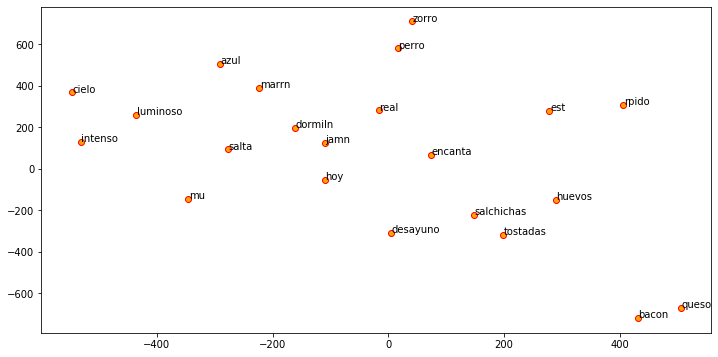

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
    
# Obsérvese que la distribución de palabras es más coherente que en  el caso anterior con Word2Vec
# Sin duda el modelo entrenado con nuestro pequeño corpus
# se comporta peor que un modelo universal entrenado con muchos datos

## Obtenemos los embeddings para cada documento, y los utilizamos para obtener clusters con el algoritmo K-Means

In [15]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,El cielo es azul y luminoso.,tiempo,2
1,¡Me encanta este cielo azul y luminoso!,tiempo,2
2,El zorro marrón es rápido y salta sobre el perro que es dormilón.,animales,1
3,"Un desayuno real tiene salchichas, jamón, bacon, huevos, tostadas y queso",alimentos,0
4,"¡Me encanta el jamón, los huevos, las salchichas y el bacon!",alimentos,0
5,"¡El zorro marrón es rápido, y el perro azul es un dormilón!",animales,1
6,El cielo es azul intenso y hoy está muy luminoso,tiempo,2
7,"¡El perro es un dormilón, pero el zorro es mu rápido!",animales,1
